In [1]:
# coding: utf-8
# Please use Python 2.
# Check if all the required packages are installed.
# Please use Theano as backend of Keras.
# Using IPython or Jupyter Notebook to run this code is strongly recommended!
# Run line by line or block by block, and you can config some important parameters
# and output whatever you want!

In [2]:
import sys, os, collections, subprocess, re, csv
import nltk, codecs
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from util import *
from PairWiseRanker import *

Using TensorFlow backend.


In [3]:
from IPython.display import clear_output

In [4]:
from copy import deepcopy

In [5]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\python35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
UNKNOWN_WORD = ':-)'

In [7]:
data_dir = 'data/'
fn = {'trn':data_dir + 'WikiQA-train.tsv', 'dev':data_dir + 'WikiQA-dev.tsv', 'test':data_dir + 'WikiQA-test.tsv'}

In [8]:
word2vec_dir = 'data/'
EMBEDDING_DIM = 50
word2vec_fn = word2vec_dir + 'glove.6B.%dd.txt' % EMBEDDING_DIM

In [9]:
#read_data = lambda fn : pd.read_csv(fn, sep='\t', header=0, index_col='QuestionID')
def read_data(f):
    data = pd.read_csv(f, sep='\t', header=0, quoting=csv.QUOTE_NONE)
    data['QAID'] = data['QuestionID'] + '*' + data['SentenceID']
    data.index = data['QAID']
    for col in ['Question', 'Sentence']:
        data[col] = list(map(lambda x : x.lower(), data[col]))
    questions = dict(zip(data['QuestionID'], data['Question']))
    return data, questions

In [10]:
data, questions = {}, {}
for k in fn:
    data[k], questions[k] = read_data(fn[k])
    print(k, data[k].shape, len(set(data[k]['QAID'])))

dev (1130, 8) 1130
trn (20360, 8) 20360
test (2351, 7) 2351


In [97]:
data_trn, data_dev, data_test = data['trn'], data['dev'], data['test'] # for convienience

In [98]:
# distribution of number of answers each question has
for k in fn:
    if k == 'test':
        continue
    grp = data[k]['Label'].groupby(data[k]['QuestionID'])
    print(k, '\n', grp.agg(lambda v : v.sum()).value_counts())

dev 
 1    115
2      9
4      1
3      1
Name: Label, dtype: int64
trn 
 0    1245
1     745
2     103
3      20
7       2
5       1
6       1
4       1
Name: Label, dtype: int64


In [99]:
t = set(questions['trn']), set(questions['dev']), set(questions['test'])
print(len(t[0]), len(t[1]), len(t[2]), len(t[0] | t[1] | t[2]), sum([len(v) for v in t]))

2118 126 243 2487 2487


In [14]:
# qtokens = {k:{qid:nltk.word_tokenize(q) for qid, q in questions[k].items() } for k in fn }

In [15]:
wnl = WordNetLemmatizer()
regex_tokenizer = RegexpTokenizer(r'\w+')
lancaster = nltk.LancasterStemmer()
def sentence2words(sent):
    res = {}
    res['tokens'] = nltk.word_tokenize(sent)
    res['words'] = regex_tokenizer.tokenize(sent)
    res['lemma'] = [wnl.lemmatize(w) for w in res['words']]
    res['stems'] = [lancaster.stem(w) for w in res['words']]
    res['words_not_stop'] = filter(lambda word : word not in stopwords.words('english'), res['words'])
    res['stems_not_stop'] = [lancaster.stem(w) for w in res['words_not_stop']]
    res['lemma_not_stop'] = [wnl.lemmatize(w) for w in res['words_not_stop']]
    return res

In [16]:
tps = ['words', 'stems', 'words_not_stop', 'stems_not_stop', 'lemma', 'lemma_not_stop']

In [17]:
sent_words = dict()

In [18]:
for k in fn:# fn:
    for qid, q in questions[k].items():
        print(q)
        sent_words[qid] = sentence2words(q)
    d = data[k]
    for qaid in d.index:
        sent_words[qaid] = sentence2words(d.get_value(qaid, 'Sentence'))

what is article 5 about
where are colors on stoplight
when did the trojan war take place
what is gravy made of
what are arizona's symbols
what hormones produce thyroid
what is bilirubin total
who sings stand by me
what are banana plugs for
when was kirstie alley on cheers
what is the name of chris cornell's band?
what is an "n.m?
what does the federal reserve do
who is the highest scoring nba player
who is carlos pena on big time rush
what is chicken chow mein
what are the boundaries of the pelvic outlet
what area code is 949
where was jfk buried
what year was elvis born
how many xbox 360 games are there
what does a plus-minus sign mean
what is the function of albumin?
what are risk for infections
how many people were killed in the oklahoma city bombing
what is associates arts degree
what year did john adams become  president?
who won the 1998 world cup
who makes triumph motorcycles
what kind of company is microsoft?
what is ibrix
where did the olmecs come from
what channel is shopnbc 

what is the country with highest life expectancy
how will a uk collection company collect money when you are in the usa
what is compatible with directx 9.0b
how does a solid state drive work
what happens at the end of toy story 3
what is a registered agent for an llc
what does automatic paper feeder on printers mean
where did hurricane katrina begin
who played in the 2010 nba finals
who said dallas cowboys were america's team
when does the seas second season on hardcore pawn start
what is transcendental wild oats about
what is futanaria
what is crohn's and colitis
where is diana prince from
where is the palatine canal
what was the first police department in the united states?
what are sanuks made of
who is the husband of betty ford
what does base jumping stand for
how many bones are in the skeletal system is composed of 306 bones
what is the singer stevie wonders full name
who is the ceo of facebook
when did daylight savings time start
how many babies are in a typical raccoon litter
wh

what organisms cannot grow on a glucose salt medium
who won the most nba championships
how much money does steve jobs make a year
what forces are included in the coalition force
what does the tear tattoo mean
what is caused by the human immunodeficiency virus?
where did the early humans live?
when is administrative assistant day
what are the impacts of information communication technology to public relation practices
what is a league in the sea
how is kafka like the trial
what was muhammad's vision
how much more time does chemo give to people with renal cancer
how do you know if something is the golden ratio
what is flour made from
how many percent is a basis point
how many public universities are in the state of louisiana
how does planned parenthood fund abortions?
what is libya's imr
what is cold flush
how many presidents of the us
what is an irregular heartbeat pvc
what numbers the louisiana
what is endodontic dentistry
where is the country andorra located
when was the sydney harbou

how many 1969 dodge coronets were made?
what are the factors of production for digital cameras
how did neil armstrong affect the united states
where was the outsiders book wrote at
what temperature is a salt ice bath
what is the address of mother's park & ride in wayne nj
how is asp.net different from .net
where did the persian war take place
where were the winter olympics in 2006
what is the legal definition of "natural born citizen"?
how tall are the members of tlc
what is ast and alt on complete metabolic panel
how old old is xp operating system
what does add my two cents mean
when is world war hulk movie come
who makes nexen tires
who is on the quarter
where is bloemfontein in africa
what is the prognosis of stomach cancer
what is a cervix childbirth
what is the value of understanding cross-cultural psychology?
what are stink bombs made of
how many albums has eminem sold in his career
who won the women's world cup
when did kurt cobain kill himself
what kind of earthquake was haiti


what does gringo mean
what is a brindle boxer
who is the richest man alive in houston?
how latin america has changed us culture
what are the rivers in india
when does sons of anarchy return 2011
when did strawberry shortcake dolls appear
what is evoked otoacoustic emissions
what is bracketing in photography
who destroyed street cars
where does the return address go on mail
how many brothels were there in the united states in 1840's
who invented geothermal energy technology
what is right to set off payments
what implication(s) does the law of conservation of matter have for humans?
where is mint mark on liberty standing half
what genre is where the red fern grows
how many gray wolves are in the world
what antigen in present in type o+ and o- blood
what is polyester in packaging pet
what is another name for cpu
what is a discipline of study
what produces primary xylem?
what printmaking process doesn't require the text to be reversed
who do they say the son of man ...
what you need short 

what is the name for an old horse-drawn vehicle
how is traffic from palmdale to santa clarita?
how was marijuana discovered
who is on the hundred dollar bill
what is schedule 4 drugs
how much square feet is an acre
what is 5 1 arm mortgage
what are geologists currently researching
what division is boise state football
what is the lombardi trophy made of?
how are public schools funded
how did the new york red bulls started in the mls
who sings better off dead in better off dead
what is a forward in soccer
who wrote white christmas
what is metformin used for
what county is cambria wi in
what are four thirds cameras
what are web related servers
when was the declaration of independence  signed?
where does cellular respiration occur
who was john f kennedy up against
what was galileo galilei's personality
where is the rhine river located on a map
how big is auburndale florida
where can i play pokemon cards
how far is reevesville,sc?
how did joan crawford die?
what is lifespan development in 

how is today special?
how much chicago snow did we get in 1979
who owns popeyes chicken
how many vehicles are registered in the us
what percent of total energy is solar energy
when was me and bobby mcgee first recorded?
what raid levels use striping
how many stripes on the flag
what is sign of cancer
how many jets fly with the president's plane
what types of trees, flowers, or plants are commonly found in canada
what year did phil mellor die at iom tt wiki
how many eukaryotic cells are in a animal?
what is the 8-fold plan to end suffering
what is the function of an epithelial free surface that is smooth?
who deregulated the banks
what is soulja boy's latest song
what day does election results for a new governor start in nj
how did edgar allan poe die?
what cards do you need in poker to get a royal flush
who was bush's national security advisor
how many millions of years have great white sharks been around?
what country is the largest stalagmite
where is the valley at in los angeles
how

when was the battle at tombstone fought
when were forever stamps introduced
who shot malcolm x
how much does united states spend on health care
who owns land rover
how long before symptoms of deadly mushrooms
where was tycho brahe when he discovered mars
what are the players in quidditch?
who is on the ways and means committee
what is extreme right wing
where is bubbles the chimp now
what is the hangover 2 about?
how many states have open carry gun laws
what do you call to the grade six pupils?
what does leeroy jenkins mean
what is romania like?
what is the lmm engine
what kind of books does debbie macomber writes
what ancient cultures had marketplaces
what did daniel interpret to nabucodonosor chapter 2,3
what to do for low lymphocyte count
what is the largest major league sport in the world?
what are the different types of cross country skiing
what is minimum wage of 2010
who is the actor that plays harry potter
how is canada's health care
how much of us 75 is 4 lane
how old julio ce

who is bj's wholesale club
when did they establish the song rocketeer
when was america pioneered
when did playhouse square reopen?
what is 1/10 net 30
what are the economics of the netherlands
what is a good leg press
when was jesus baptized
what is muse's lead singer's name
what is wrong with gary busey's face
what branch of army was dwight d eisenhower in
how much does 1952 us 1/2 franc weight
who wrote rhythm of the ancient mariner
where did erisa come from
what is that dot on the forehead of indian women\
when was bandaranaike airport built
who owns smirnoff
what is cu the element
where are cover girl cosmetics sold
what county is wilton ca in
what cars have smart key systems
who hit the first home run at riverfront stadium?
how many terms did calvin coolidge serve
who is juliet huddy dating
what about me moving pictures
what are lobbying groups
who owns joe's crab shack
who wrote stand by me
what happened to lynne on real housewives of orange county
what is the ideal mean radiant 

what track and field event for me?
where is the original a team
what key is ludacris move bitch in?
what model years did the ford focus zx3 have the zetec engine
what will happen to the hills cast members now
how do you determine pump frame type
how many albums has dmx sold to this date
what is david from the bible diet
what country is dubai in
what is tmz stand for
when is it memorial day
what county is north myrtle beach in sc
who was in full metal jacket
when did lucy stone died
where was the tsunami in 2005
what is a community property state
what are the effects of low progesterone levels in a woman
what state is jakarta in?
what are the colors of a rainbow
who sings i am a man of constant sorrow
what is baume hydrochloric acid
when a cell divides
where is the rosetta stone located in 2010
what are the 7 continents
where was skiing originated
how many consoles has xbox 360 sold
what is reagan known for
what region of france is montargis in?
what is "thin film" technology
what is da

what does human sperm consist of?
when was the tacoma bridge collapse?
what is a group of deer called
what is the ingredient in mustard
where does a flea live
what county is coatesville indiana located in
what are land parcels
who are the members of the climax blues band?
how did harmon killebrew get strong
what does a liquid oxygen plant look like
what religion is primary in africa?
what is a monarch to a monarchy
who is the founder of twitter
what was the actress who played the pink power ranger
how much is centavos in mexico
how much did waterboy grossed
what is the main component of vaccines
how is whooping cough distinguished from similar diseases
how many humps on a camel
what does hair testing show
how does interlibrary loan work
what are some legal uses of meth
what is the purpose of child support?
who owns youtube
what county is bolingbrook il in?
what was the first year of kentucky derby
what is in a tequila sunrise?
what is a letterbox movie
what is range in math
what are th

In [19]:
#first_word = lambda sent : sent[:sent.find(' ')]
first_token = lambda tokens : tokens[0]
second_token = lambda tokens : UNKNOWN_WORD if len(tokens) == 1 else tokens[1]
first_two_tokens = lambda tokens : ' '.join(tokens[:2])

In [20]:
for k in fn:
    for col, func in [('token1', first_token), ('token2', second_token), ('token12', first_two_tokens)]:
        qids = list(set(data[k]['QuestionID']))
        tmp = Series(map(func, map(lambda qid : sent_words[qid]['words'], qids)), index=qids)
        data[k][col] = tmp[data[k]['QuestionID']].values

In [21]:
def get_question_type(data_x):
    qtype = deepcopy(Series(data_x['token1'], index=data_x.index))
    qtype[data_x['token12'] == 'what year'] = 'time'
    qtype[data_x['token1'] == 'when'] = 'time'
    qtype[data_x['token12'] == 'how many'] = 'number'
    qtype[data_x['token1'] == 'where'] = 'place'
    qtype[data_x['token1'] == 'who'] = 'person'
    return qtype

In [22]:
len(set(data_trn.token1)), len(set(data_trn.token12)), len(set(data_trn.token2))

(5, 338, 286)

In [23]:
for k in fn:
    data[k]['qtype'] = get_question_type(data[k])

In [24]:
for k in fn:
    print(k, '\n')
    for tk in ['token1', 'token12']:
        print(data[k][tk].value_counts().head(10) / float(data[k].shape[0]) * 100)
    print('\n')

dev 

what        56.194690
how         12.035398
when        11.946903
where       10.000000
who          9.646018
whatever     0.176991
Name: token1, dtype: float64
what is      14.424779
what are     10.265487
when did      9.203540
how many      6.725664
where is      5.132743
what does     4.070796
what was      3.982301
what year     3.539823
when was      2.743363
who is        2.743363
Name: token12, dtype: float64


trn 

what     49.695481
how      20.859528
who      12.568762
when      9.228880
where     7.647348
Name: token1, dtype: float64
what is      19.965619
how many      7.509823
what are      4.705305
when was      3.408644
what does     3.163065
when did      2.991159
who is        2.946955
where is      2.946955
how did       2.254420
what was      1.940079
Name: token12, dtype: float64


test 

what     52.956189
how      16.205870
who      11.569545
where    10.421097
when      8.847299
Name: token1, dtype: float64
what is      22.288388
what are      5.827308
wh

In [25]:
import math

words_idf = dict()
for tp in tps:
    words_idf[tp] = dict()

for tp in tps:
    for qaid in sent_words:
        for word in set(sent_words[qaid][tp]):
            if (word in words_idf[tp]) == True:
                words_idf[tp][word] = words_idf[tp][word] + 1
            else:
                words_idf[tp][word] = 1

DocNum = len(sent_words)
for tp in tps:
    for w in words_idf[tp]:
        words_idf[tp][w] = math.log(DocNum / words_idf[tp][w], 2)


In [26]:
def count_num_cooccur_weight(x, y, tp):
    z = set(x) & set(y)
    s = 0
    for w in z:
        s = s + words_idf[tp][w]
    return s

In [27]:
#word embedding:
# readEmbedFile
from word2vec_util import * 
wordvecs = readEmbedFile(word2vec_fn)
dim = EMBEDDING_DIM

wordset2 = set()
for tp in tps:
    for w in words_idf[tp]:
        wordset2.add(w)

new_wv=dict()
for w in wordvecs:
    if (w in wordset2) == True:
        new_wv[w] = wordvecs[w]
wordvecs = new_wv
new_wv = dict()

In [28]:
#using this!!!
def count_wv_dis(x, y):
    vx = [0 for c in range(dim)]
    wn = 0
    for w in x:
        if w in wordvecs:
            wn = wn + 1
            for d in range(dim):
                vx[d] += wordvecs[w][d]
    if wn > 0:
        for d in range(dim):
            vx[d] /= wn
    vy = [0 for c in range(dim)]
    wn = 0
    for w in y:
        if w in wordvecs:
            wn = wn + 1
            for d in range(dim):
                vy[d] += wordvecs[w][d]
    if wn > 0:
        for d in range(dim):
            vy[d] /= wn
    dis = 0;
    for d in range(dim):
        dis += (vx[d] - vy[d])*(vx[d] - vy[d])
    return 0 - dis # larger, better

def count_wv_dis_weight(x, y, tp):
    vx = [0 for c in range(dim)]
    wn = 0
    for w in x:
        if w in wordvecs:
            wn = wn + words_idf[tp][w]
            for d in range(dim):
                vx[d] += wordvecs[w][d]*words_idf[tp][w]
    if wn > 0:
        for d in range(dim):
            vx[d] /= wn
    vy = [0 for c in range(dim)]
    wn = 0
    for w in y:
        if w in wordvecs:
            wn = wn + words_idf[tp][w]
            for d in range(dim):
                vy[d] += wordvecs[w][d]*words_idf[tp][w]
    if wn > 0:
        for d in range(dim):
            vy[d] /= wn
    dis = 0;
    for d in range(dim):
        dis += (vx[d] - vy[d])*(vx[d] - vy[d])
    return 0 - dis # larger, better

# for k in fn:
#     d = data[k]
#     for tp in tps:
#         func = lambda qaid : count_wv_dis_weight(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp], tp)
#         features[k][tp] = d['QAID'].apply(func)

In [29]:
encode = lambda s : codecs.encode(s, 'UTF-8')
ques_utf8 = {}
sent_utf8 = {}
for k in fn:
    for qid, q in questions[k].items():
        ques_utf8[qid] = q
    d = data[k]
    for qaid in d.index:
        sent_utf8[qaid] = d.get_value(qaid, 'Sentence')

texts = []
texts.extend(ques_utf8.values())
texts.extend(sent_utf8.values())
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(texts)
ques_seq = {qid:tokenizer.texts_to_sequences([tx])[0] for qid, tx in ques_utf8.items()}
sent_seq = {qaid:tokenizer.texts_to_sequences([tx])[0] for qaid, tx in sent_utf8.items()}
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(max([len(seq) for seq in ques_seq.values()]), max([len(seq) for seq in sent_seq.values()]))
# MAX_SENT_SEQUENCE_LENGTH = max([max([len(seq) for seq in sents_seq[k]]) for k in fn])
ques_len = Series([len(q) for q in ques_seq.values()])
sent_len = Series([len(s) for s in sent_seq.values()])
MAX_QUES_SEQUENCE_LENGTH, MAX_SENT_SEQUENCE_LENGTH = 20, 60

Found 35188 unique tokens.
23 165


In [30]:
word2vec = pd.read_csv(word2vec_fn, sep=' ', header=None, index_col=0, nrows=None, quoting=csv.QUOTE_NONE)
embedding_index = {}
for i, w in enumerate(word2vec.index):
    embedding_index[w] = word2vec.values[i]

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

words_bag = set(word2vec.index)

In [31]:
words_idf_series = {tp:Series(words_idf[tp].values(), index=words_idf[tp].keys()) for tp in words_idf}

In [32]:
def words_of_sentence_to_vector(words, tp, use_weight=True):
    shp = (len(words), EMBEDDING_DIM)
    try:
        if use_weight:
            weight = np.repeat(words_idf_series[tp].loc[words], EMBEDDING_DIM).values.reshape(shp)
            return (word2vec.loc[words] * weight).mean().values    
        else:
            return (word2vec.loc[words]).mean().values
    except: # none of words are in word2vec
        return np.zeros(shp)
def get_sent_vetor_df(q_words):
    q_vecs = dict(zip(q_words.keys(), map(lambda words : words_of_sentence_to_vector(words, 'words', use_weight=False), q_words.values())))
    q_vecs = DataFrame(q_vecs).T
    q_vecs_wgt = dict(zip(q_words.keys(), map(lambda words : words_of_sentence_to_vector(words, 'words', use_weight=True), q_words.values())))
    q_vecs_wgt = DataFrame(q_vecs_wgt).T
    #q_vecs_wgt.columns = map(lambda col : col)
    q_vecs_merged = pd.concat([q_vecs, q_vecs_wgt], axis=1)
    return q_vecs_merged

## calculate features

In [33]:
features = {key:DataFrame({}, index=data[key].index) for key in fn}
features_trn = features['trn']
features_dev = features['dev']
features_test = features['test']
tps_wgt = list(map(lambda v : v + '_wgt', tps))
tps_wv = list(map(lambda v : v + '_wv', tps))
tps_wv_wgt = list(map(lambda v : v + '_wgt', tps_wv))

In [34]:
# words, stems
for k in fn:
    d = data[k]
    for tp in tps:
        func = lambda qaid : count_num_cooccur(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp])
        features[k][tp] = d['QAID'].apply(func)
        func = lambda qaid : count_num_cooccur_weight(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp], tp)
        features[k][tp + '_wgt'] = d['QAID'].apply(func)
        func = lambda qaid : count_wv_dis(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp])
        features[k][tp + '_wv'] = d['QAID'].apply(func)
        func = lambda qaid : count_wv_dis_weight(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp], tp)
        features[k][tp + '_wv_wgt'] = d['QAID'].apply(func)

In [35]:
# question type
for k in fn:
    f, d = features[k], data[k]
    for col in ['token1', 'qtype']:
        f[col] = data[k][col]
    f['qtype_time'] = (d['qtype'] == 'time') + 0
    f['qtype_number'] = (d['qtype'] == 'number') + 0
    f['year'] = list(map(lambda sent : int(re.search('[0-9]{4}', sent) != None), d.Sentence))
    f['number'] = list(map(lambda sent : int(re.search('[0-9]+', sent) != None), d.Sentence))
    f['number'] = f['number'] - f['year']
    f['num_unknown'] = list(map(lambda words : len(set(words) - words_bag), #np.sum(np.logical_not(np.in1d(words, word2vec.index)))
                           map(lambda qaid : sent_words[qaid]['words'], d.index)))

In [36]:
# qa_vectors = {}
# for k in fn:
#     q_words = {qid:sent_words[qid]['words'] for qid in set(data[k]['QuestionID'])}
#     q_vec_df = get_sent_vetor_df(q_words)
#     q_vec_df = q_vec_df.loc[data[k]['QuestionID']]
#     q_vec_df.index = data[k].index
#     a_words = {qaid:sent_words[qaid]['words'] for qaid in data[k].index}
#     a_vec_df = get_sent_vetor_df(a_words)
#     qa_vectors[k] = pd.concat([q_vec_df, a_vec_df], axis=1)

In [37]:
dummies = {}
features_all = pd.concat(features.values(), axis=0)
dummies_all = pd.get_dummies(features_all)

In [38]:
features_all.shape, dummies_all.shape

((23841, 31), (23841, 42))

In [39]:
idx = 0
k_all = list(fn.keys())
for i in range(len(k_all)):
    k = k_all[i]
    new_idx = idx + data[k].shape[0]
    dummies[k] = dummies_all.iloc[idx:new_idx]
    print(k, idx, new_idx, dummies[k].shape, data[k].shape)
    idx = new_idx

dev 0 1130 (1130, 42) (1130, 12)
trn 1130 21490 (20360, 42) (20360, 12)
test 21490 23841 (2351, 42) (2351, 11)


In [40]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [41]:
from learning2rank.rank import RankNet, ListNet


In [42]:
models = {}

In [43]:
indiv = [1560, 'entropy', 3, 5, 5] # (0.68945635493254542,) # 0.68482672530291577,) [48, 'gini', 3, 2, 4] #(0.68573375478137377,) [1734, 'entropy', 5, 3, 4] # (0.68961935330982949,)  # 49, 'entropy', 13, 3, 5]
models['rf'] = model_rf = RandomForestClassifier(n_estimators=indiv[0], criterion=indiv[1], 
                                                 max_depth=indiv[2], min_samples_split=indiv[3], 
                                                 min_samples_leaf=indiv[4], n_jobs=-1) # 

In [44]:
#models['ada'] = model_ada = AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=.5, algorithm='SAMME.R', random_state=None)

In [45]:
models['lr_l1'] = model_lr_l1 = LogisticRegression(penalty='l1', n_jobs=-1)
models['lr_l2'] = model_lr_l2 = LogisticRegression(penalty='l2', n_jobs=-1)

In [46]:
#models['svm'] = model_svm = SVC(probability=True)

In [47]:
rk_models = {}

In [48]:
rk_models['ranknet'] = rk_model_ranknet = RankNet.RankNet()

In [49]:
#rk_models['listnet'] = rk_model_listnet = ListNet.ListNet(silent=True)

In [57]:
my_models = {}
pair_ranker = PairWiseRanker(data_trn.QuestionID, dummies['trn'], list(data_trn.Label))

In [96]:
data_trn.Label

QAID
Q1*D1-0           0
Q1*D1-1           0
Q1*D1-2           0
Q1*D1-3           1
Q1*D1-4           0
Q2*D2-0           0
Q2*D2-1           0
Q2*D2-2           0
Q2*D2-3           0
Q2*D2-4           0
Q2*D2-5           0
Q2*D2-6           0
Q5*D5-0           0
Q5*D5-1           0
Q5*D5-2           0
Q5*D5-3           0
Q5*D5-4           0
Q5*D5-5           0
Q5*D5-6           0
Q5*D5-7           0
Q6*D6-0           0
Q6*D6-1           0
Q6*D6-2           0
Q6*D6-3           0
Q6*D6-4           0
Q6*D6-5           0
Q6*D6-6           0
Q7*D7-0           0
Q7*D7-1           0
Q7*D7-2           0
                 ..
Q3041*D2805-1     0
Q3041*D2805-2     0
Q3041*D2805-3     0
Q3041*D2805-4     0
Q3041*D2805-5     0
Q3042*D2806-0     0
Q3042*D2806-1     0
Q3042*D2806-2     0
Q3042*D2806-3     1
Q3042*D2806-4     0
Q3042*D2806-5     0
Q3042*D2806-6     0
Q3042*D2806-7     0
Q3042*D2806-8     0
Q3042*D2806-9     0
Q3042*D2806-10    0
Q3042*D2806-11    0
Q3043*D2807-0     0
Q3043*D2807-1  

In [51]:
# from ParamGA import * 
# g = RFGA(data_trn.QuestionID, dummies['trn'], data_trn.Label, data_dev.QuestionID, dummies['dev'], data_dev.Label, pair_wise=False)
# g.run(NPOP=30, NGEN=20, CXPB=0.5, MUTPB=0.5)

In [52]:
indiv =[327, 'gini', 5, 5, 1] #  (0.69239713108760736,)  # [746, 'gini', 7, 6, 4] #[746, 'gini', 7, 6, 4] # 0.679 
# (0.69028072897120518,) [352, 'entropy', 5, 4, 5] # (0.69001617870665499,) [1977, 'gini', 6, 4, 5]
my_models['my_rf'] = my_models_rf = RandomForestClassifier(n_estimators=indiv[0], criterion=indiv[1], 
                                                 max_depth=indiv[2], min_samples_split=indiv[3], 
                                                 min_samples_leaf=indiv[4], n_jobs=-1)

In [53]:
for mn, md in models.items():
    md.fit(dummies['trn'].values, data_trn.Label)

c:\python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
c:\python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


load dataset


D:\QA-rankit\learning2rank\utils\NNfuncs.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  train_y, validate_y = np.split(fit_y[perm].astype(np.float32).reshape(len(fit_y), 1), [N_train])


The number of data, train: 19342 validate: 1018
prepare initialized model!


  2%|█▎                                                                             | 86/5000 [00:00<00:30, 160.25it/s]

step: 100
NDCG@100 | train: 0.06452294876005761, test: 0.23713152941749518


  4%|██▉                                                                           | 190/5000 [00:01<00:33, 144.84it/s]

step: 200
NDCG@100 | train: 0.032579349827406574, test: 0.1912489490761268


  6%|████▌                                                                         | 294/5000 [00:02<00:32, 146.74it/s]

step: 300
NDCG@100 | train: 0.2559710872457922, test: 0.2600356072897981


  8%|█████▉                                                                        | 377/5000 [00:02<00:32, 141.72it/s]

step: 400
NDCG@100 | train: 0.023620651254141253, test: 0.1320915277310032


 10%|███████▌                                                                      | 482/5000 [00:03<00:31, 142.81it/s]

step: 500
NDCG@100 | train: 0.04675524336942765, test: 0.03906581881938752


 12%|█████████▏                                                                    | 586/5000 [00:04<00:30, 144.02it/s]

step: 600
NDCG@100 | train: 0.025861897998876705, test: 0.052107432422364125


 14%|██████████▋                                                                   | 684/5000 [00:05<00:32, 134.04it/s]

step: 700
NDCG@100 | train: 0.26940621175844076, test: 0.31770731107801525


 16%|████████████▍                                                                 | 797/5000 [00:05<00:31, 133.05it/s]

step: 800
NDCG@100 | train: 0.30758129732583506, test: 0.32820947586618443


 18%|█████████████▉                                                                | 891/5000 [00:06<00:31, 130.43it/s]

step: 900
NDCG@100 | train: 0.3062598473392618, test: 0.31520753755952313


 20%|███████████████▍                                                              | 990/5000 [00:07<00:30, 129.50it/s]

step: 1000
NDCG@100 | train: 0.26943234121650333, test: 0.33029457788182626


 22%|████████████████▊                                                            | 1092/5000 [00:08<00:30, 129.13it/s]

step: 1100
NDCG@100 | train: 0.03896306767850353, test: 0.14236713504062415


 24%|██████████████████▍                                                          | 1198/5000 [00:09<00:29, 129.08it/s]

step: 1200
NDCG@100 | train: 0.01572086599685292, test: 0.11463746774924458


 26%|███████████████████▉                                                         | 1292/5000 [00:10<00:29, 126.41it/s]

step: 1300
NDCG@100 | train: 0.03127649073552252, test: 0.18666108775575477


 28%|█████████████████████▎                                                       | 1387/5000 [00:11<00:28, 126.02it/s]

step: 1400
NDCG@100 | train: 0.07530712406755267, test: 0.11722181104180569


 30%|██████████████████████▉                                                      | 1487/5000 [00:11<00:27, 125.86it/s]

step: 1500
NDCG@100 | train: 0.06625682898817271, test: 0.11766056323581134


 32%|████████████████████████▌                                                    | 1593/5000 [00:12<00:26, 126.21it/s]

step: 1600
NDCG@100 | train: 0.1254209992579194, test: 0.12053400327017937


 34%|██████████████████████████▏                                                  | 1698/5000 [00:13<00:26, 126.24it/s]

step: 1700
NDCG@100 | train: 0.08610544657487712, test: 0.12835733860570936


 36%|███████████████████████████▌                                                 | 1786/5000 [00:14<00:25, 126.12it/s]

step: 1800
NDCG@100 | train: 0.26613852833557816, test: 0.2950314676734391


 38%|█████████████████████████████                                                | 1890/5000 [00:15<00:24, 124.81it/s]

step: 1900
NDCG@100 | train: 0.16430467534706011, test: 0.031793418383738024


 40%|██████████████████████████████▌                                              | 1986/5000 [00:15<00:24, 124.41it/s]

step: 2000
NDCG@100 | train: 0.15667559098769093, test: 0.11359575367311887


 42%|████████████████████████████████▏                                            | 2094/5000 [00:16<00:23, 125.06it/s]

step: 2100
NDCG@100 | train: 0.248622601574151, test: 0.2205919484196808


 44%|█████████████████████████████████▋                                           | 2187/5000 [00:17<00:22, 125.60it/s]

step: 2200
NDCG@100 | train: 0.2683453729661475, test: 0.310583504273359


 46%|███████████████████████████████████▎                                         | 2297/5000 [00:18<00:21, 126.09it/s]

step: 2300
NDCG@100 | train: 0.02015702558866816, test: 0.05196784871540402


 48%|████████████████████████████████████▊                                        | 2391/5000 [00:18<00:20, 126.52it/s]

step: 2400
NDCG@100 | train: 0.2915319078652978, test: 0.3119189968955469


 50%|██████████████████████████████████████▎                                      | 2488/5000 [00:19<00:19, 127.03it/s]

step: 2500
NDCG@100 | train: 0.27514907148168327, test: 0.30291841969987904


 52%|███████████████████████████████████████▊                                     | 2585/5000 [00:20<00:19, 126.69it/s]

step: 2600
NDCG@100 | train: 0.21548491068645426, test: 0.22725503409472067


 54%|█████████████████████████████████████████▎                                   | 2683/5000 [00:21<00:18, 126.66it/s]

step: 2700
NDCG@100 | train: 0.23989794004596054, test: 0.2801596225835171


 56%|██████████████████████████████████████████▉                                  | 2792/5000 [00:21<00:17, 127.06it/s]

step: 2800
NDCG@100 | train: 0.22609880484133993, test: 0.28335573592439234


 58%|████████████████████████████████████████████▎                                | 2881/5000 [00:22<00:16, 127.20it/s]

step: 2900
NDCG@100 | train: 0.0569838519751908, test: 0.1737903616399549


 60%|██████████████████████████████████████████████                               | 2994/5000 [00:23<00:15, 127.66it/s]

step: 3000
NDCG@100 | train: 0.11427936341274542, test: 0.2250801822896668


 62%|███████████████████████████████████████████████▋                             | 3094/5000 [00:24<00:14, 127.67it/s]

step: 3100
NDCG@100 | train: 0.2919416482254902, test: 0.33507825239321604


 64%|█████████████████████████████████████████████████▎                           | 3199/5000 [00:25<00:14, 127.75it/s]

step: 3200
NDCG@100 | train: 0.27130971650472996, test: 0.307541320776417


 66%|██████████████████████████████████████████████████▌                          | 3285/5000 [00:25<00:13, 127.00it/s]

step: 3300
NDCG@100 | train: 0.2778811406435203, test: 0.32875095117832287


 68%|████████████████████████████████████████████████████▏                        | 3388/5000 [00:26<00:12, 127.10it/s]

step: 3400
NDCG@100 | train: 0.03949830791630703, test: 0.05203737949740851


 70%|█████████████████████████████████████████████████████▊                       | 3491/5000 [00:27<00:11, 127.27it/s]

step: 3500
NDCG@100 | train: 0.26875437781556993, test: 0.290220026395961


 72%|███████████████████████████████████████████████████████▍                     | 3599/5000 [00:28<00:10, 127.54it/s]

step: 3600
NDCG@100 | train: 0.21826183243725603, test: 0.3087973349254077


 74%|████████████████████████████████████████████████████████▊                    | 3688/5000 [00:28<00:10, 127.69it/s]

step: 3700
NDCG@100 | train: 0.28400110067783124, test: 0.3349349882081729


 76%|██████████████████████████████████████████████████████████▍                  | 3791/5000 [00:29<00:09, 127.87it/s]

step: 3800
NDCG@100 | train: 0.24649418515104377, test: 0.2530445473064537


 78%|███████████████████████████████████████████████████████████▉                 | 3895/5000 [00:30<00:08, 128.00it/s]

step: 3900
NDCG@100 | train: 0.023221962250920394, test: 0.12541794315486912


 80%|█████████████████████████████████████████████████████████████▍               | 3988/5000 [00:31<00:07, 127.49it/s]

step: 4000
NDCG@100 | train: 0.29767236817441534, test: 0.3325218769487658


 82%|███████████████████████████████████████████████████████████████              | 4095/5000 [00:32<00:07, 127.67it/s]

step: 4100
NDCG@100 | train: 0.2067843407732887, test: 0.23995510885662186


 84%|████████████████████████████████████████████████████████████████▋            | 4198/5000 [00:32<00:06, 127.80it/s]

step: 4200
NDCG@100 | train: 0.2817340312200421, test: 0.3103084217299499


 86%|██████████████████████████████████████████████████████████████████▏          | 4299/5000 [00:33<00:05, 127.74it/s]

step: 4300
NDCG@100 | train: 0.26110544549587156, test: 0.30214587298134377


 88%|███████████████████████████████████████████████████████████████████▌         | 4386/5000 [00:34<00:04, 127.64it/s]

step: 4400
NDCG@100 | train: 0.2837803694167817, test: 0.3004920512022118


 90%|█████████████████████████████████████████████████████████████████████▏       | 4494/5000 [00:35<00:03, 127.86it/s]

step: 4500
NDCG@100 | train: 0.1572578556819741, test: 0.22230695422306726


 92%|██████████████████████████████████████████████████████████████████████▋      | 4588/5000 [00:35<00:03, 127.47it/s]

step: 4600
NDCG@100 | train: 0.2897765420796902, test: 0.2927936465550284


 94%|████████████████████████████████████████████████████████████████████████▏    | 4688/5000 [00:36<00:02, 127.28it/s]

step: 4700
NDCG@100 | train: 0.27522400989309675, test: 0.293651844950127


 96%|█████████████████████████████████████████████████████████████████████████▊   | 4797/5000 [00:37<00:01, 127.45it/s]

step: 4800
NDCG@100 | train: 0.27571442420936315, test: 0.2777803268534456


 98%|███████████████████████████████████████████████████████████████████████████▎ | 4887/5000 [00:38<00:00, 127.53it/s]

step: 4900
NDCG@100 | train: 0.03949830791630703, test: 0.05203737949740851


100%|████████████████████████████████████████████████████████████████████████████▊| 4991/5000 [00:39<00:00, 127.66it/s]

step: 5000
NDCG@100 | train: 0.2037654594049832, test: 0.18695026645892066


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 127.20it/s]


save the model
save the optimizer


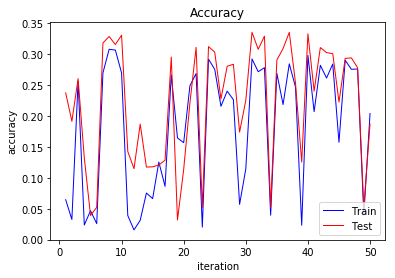

In [54]:
# %%capture
for mn in rk_models: # ['listnet']: # 
    args = {}
    if mn == 'ranknet':
        args = {} # {'batchsize':100, 'n_iter':5000, 'n_units1':512, 'n_units2':128, 'tv_ratio':0.95}
    elif mn == 'listnet':
        args = {'batchsize':100, 'n_epoch':1, 'n_units1':32, 'n_units2':16, 'tv_ratio':0.9}
    rk_models[mn].fit(dummies['trn'].values, data_trn.Label, **args)

# clear_output()

In [58]:
from sklearn.utils.multiclass import type_of_target
x = [[0],
 [0],
 [0],
 [1],
 [1],
 [1]]
type_of_target(x)

'binary'

In [59]:
for mn in my_models:
    pair_ranker.fit(my_models[mn], mn)

In [60]:
#Series(model_rf.feature_importances_, index=features_trn.columns).sort_values(ascending=False)

In [61]:
sfn = fn.keys() # specify a subset of fn

In [62]:
preds = {k:{mn:md.predict_proba(dummies[k]) for mn, md in models.items()} for k in sfn}

In [63]:
rk_preds = {k:{mn:md.predict(dummies[k].values) for mn, md in rk_models.items()} for k in sfn}

In [64]:
my_preds = {k:{mn:pair_ranker.predict(data[k]['QuestionID'], dummies[k], mn) for mn in my_models} for k in sfn}

In [65]:
ranks = {k:deepcopy(dummies[k]) for k in fn}
dummy_rank_features = {k:deepcopy(dummies[k]) for k in fn}
rank_trn, rank_dev, rank_test = ranks['trn'], ranks['dev'], ranks['test']
all_tps = tps + tps_wgt + tps_wv + tps_wv_wgt + list(models.keys()) + list(rk_models.keys()) + list(my_models.keys())
for k in sfn:
    rk = ranks[k]
    for col in ['QuestionID', 'SentenceID']:
        rk[col] = data[k][col]
    if k != 'test':
        rk['Label'] = data[k]['Label']
    for mn in models:
        rk[mn] = preds[k][mn][:, 1] # larger is better
    for mn in rk_models:
        rk[mn] = rk_preds[k][mn][:, 0]
    for mn in my_models:
        rk[mn] = my_preds[k][mn]
    grp = rk.groupby('QuestionID')
    for tp in all_tps:
        col = 'rank_' + tp
        rk[col] = grp[tp].rank(method='min', ascending=False).astype(int)  
        rk.sort_values(['QuestionID', col], inplace=True)
        # add one Strictly Increasing Monotonically vector to avoid same ranks
        b = np.ones(rk.shape[0]).cumsum()
        rk[col] += b
        grp = rk.groupby('QuestionID')
        rk[col] = grp[col].rank(method='min', ascending=True).astype(int)  
        dummy_rank_features[k][col] = rk[col]

In [66]:
for k in sfn:
    if k in ['test', 'trn']:
        continue
    print(k)
    rk = ranks[k]
    for tp in all_tps:
        col = 'rank_' + tp
        rk.sort_values(['QuestionID', col], inplace=True)
        grp = rk.Label.groupby(rk.QuestionID)
        print('\t', '{: <20}'.format(tp), np.round([MAP(grp), MRR(grp), MAP(grp, keep_no_ans=False), MRR(grp, keep_no_ans=False)], 5))

dev
	 words                [ 0.66772  0.67436  0.66772  0.67436]
	 stems                [ 0.66973  0.67913  0.66973  0.67913]
	 words_not_stop       [ 0.66973  0.67913  0.66973  0.67913]
	 stems_not_stop       [ 0.67604  0.6848   0.67604  0.6848 ]
	 lemma                [ 0.67396  0.68272  0.67396  0.68272]
	 lemma_not_stop       [ 0.67396  0.68272  0.67396  0.68272]
	 words_wgt            [ 0.65171  0.65746  0.65171  0.65746]
	 stems_wgt            [ 0.68458  0.69342  0.68458  0.69342]
	 words_not_stop_wgt   [ 0.68458  0.69342  0.68458  0.69342]
	 stems_not_stop_wgt   [ 0.67908  0.68725  0.67908  0.68725]
	 lemma_wgt            [ 0.68048  0.68905  0.68048  0.68905]
	 lemma_not_stop_wgt   [ 0.68048  0.68905  0.68048  0.68905]
	 words_wv             [ 0.58868  0.58786  0.58868  0.58786]
	 stems_wv             [ 0.59006  0.59082  0.59006  0.59082]
	 words_not_stop_wv    [ 0.59006  0.59082  0.59006  0.59082]
	 stems_not_stop_wv    [ 0.55255  0.55688  0.55255  0.55688]
	 lemma_wv          

In [67]:
# #res = collections.defaultdict(dict)
# print sfn, '\n'
# print ' ' * 15, '{: >15}\t{: >15}'.format('MAP', 'MRR') 
# for tp in tps + tps_wgt + models.keys() + rk_models.keys() + my_models.keys(): # ['rf']: #
#     print '{: >20}'.format(tp), 
#     for k in sfn:
#         if k in ['test', 'trn']:
#             continue
#         col = 'rank_' + tp
#         ranks[k][['QuestionID', 'SentenceID', col]].sort_values(['QuestionID', col]).to_csv('rank.txt', sep='\t', header=False, index=False)
#         out = commands.getoutput('python eval.py rank.txt %s' % fn[k])
#         m = re.search('MAP: ([.0-9]+)\nMRR ([.0-9]+)', out)
#         print '\t%f\t%f' % (float(m.group(1)), float(m.group(2))),' ',
#     print ''

In [68]:
def rank_and_evaluate(y, k):
    '''
    if k is 'test', then this func will only rank, not evaluate 
    '''
    d = DataFrame({}, data[k].index)
    d['y'] = y
    cols = ['QuestionID', 'SentenceID']
    if k != 'test':
        cols.append('Label')
    for col in cols:
        d[col] = data[k][col]
    
    
    grp = d.groupby('QuestionID')
    d['rank'] = grp['y'].rank(method='min', ascending=False).astype(int)    
    
    d.sort_values(['QuestionID', 'rank'], inplace=True)
    res = dict()
    res['rank_df'] = d
    if k == 'test':
        return res
    grp = d.Label.groupby(d.QuestionID)
    res['my_MAP'] = MAP(grp, keep_no_ans=False)
    res['my_MRR'] = MRR(grp, keep_no_ans=False)
    d[['QuestionID', 'SentenceID', 'rank']].sort_values(['QuestionID', 'rank']).to_csv('rank.txt', sep='\t', header=False, index=False)
    out = subprocess.getoutput('python eval.py rank.txt %s' % fn[k])
    m = re.search('MAP: ([.0-9]+)\nMRR ([.0-9]+)', out)
    res['MAP'] = float(m.group(1))
    res['MRR'] = float(m.group(2))
    return res    

def save_final_rank(df, dst_fn='final_rank.txt', rank_col='rank', 
                    save_cols=['QuestionID', 'SentenceID', 'rank'], sort_by_cols=['QuestionID', 'rank'], re_rank=False):
    if re_rank:
        col = rank_col
        df.sort_values(['QuestionID', col], inplace=True)
        # add one Strictly Increasing Monotonically vector to avoid same ranks
        b = np.ones(df.shape[0]).cumsum()
        df[col] += b
        grp = df.groupby('QuestionID')
        df[col] = grp[col].rank(method='min', ascending=True).astype(int)  
    df[save_cols].sort_values(sort_by_cols).to_csv(dst_fn, sep='\t', header=False, index=False)    

def resample(rt, Xs, Y):
    if rt == None or rt == 0:
        return Xs, Y
    n = Y.shape[0]
    n1 = Y.sum()
    n0 = n - n1
    cls_idx = np.arange(n)
    pos_cls_idx = cls_idx[Y==1]
    neg_cls_idx = cls_idx[Y==0]
    pos_sample = np.random.choice(pos_cls_idx, size=int(n0 / float(rt)) - n1, )
    new_cls_idx = np.concatenate([neg_cls_idx, pos_cls_idx, pos_sample])
    np.random.shuffle(new_cls_idx)
    print(n0, n1, n, int(n0 / float(rt)) - n1, new_cls_idx.shape)
    new_Y = Y[new_cls_idx]
    new_Xs = [X[new_cls_idx] for X in Xs]
    return new_Xs, new_Y


In [69]:
#ques_len.hist()

In [70]:
#sent_len.hist()
#sent_len[sent_len<200].hist()

In [71]:
from keras.preprocessing.sequence import pad_sequences
sent_pad = dict(zip(sent_seq.keys(), pad_sequences(sent_seq.values(), maxlen=MAX_SENT_SEQUENCE_LENGTH, padding='post', truncating='post')))
ques_pad = dict(zip(ques_seq.keys(), pad_sequences(ques_seq.values(), maxlen=MAX_QUES_SEQUENCE_LENGTH, padding='post', truncating='post')))
ques_as_sent_pad = dict(zip(ques_seq.keys(), pad_sequences(ques_seq.values(), maxlen=MAX_SENT_SEQUENCE_LENGTH, padding='post', truncating='post')))

In [72]:
sent_pad_df = DataFrame(list(sent_pad.values()), index=sent_pad.keys())

In [73]:
ques_pad_df = DataFrame(list(ques_pad.values()), index=ques_pad.keys())

In [74]:
ques_as_sent_pad_df = DataFrame(list(ques_as_sent_pad.values()), index=ques_as_sent_pad.keys())

In [75]:
paddata = collections.defaultdict(dict)
for k in fn:
    paddata[k] = {'ques':ques_pad_df.loc[data[k]['QuestionID']], 
                  'ques_as_sent':ques_as_sent_pad_df.loc[data[k]['QuestionID']],
                  'sent':sent_pad_df.loc[data[k]['QAID']]}

In [76]:
num_output_class = 1

In [77]:
label = {}
for k in sfn:
    if k == 'test':
        continue
    tmp = data[k]['Label'].values
    if num_output_class == 1:
        label[k] = tmp
    elif num_output_class == 2:
        label[k] = np.array([1 - tmp, tmp]).T

## adapted CNN

In [78]:
use_add_features = True
num_output_class = 1
features_used = dummy_rank_features
add_features_dim = features_used['trn'].shape[1] if use_add_features else None
X, Y = {}, {}
for k in sfn:
    X[k] = [paddata[k]['ques'].values, paddata[k]['sent'].values]
    if k != 'test':
        Y[k] = label[k]
    if use_add_features:
        X[k].append(features_used[k].values)

In [79]:
from MyCNN import *
cnn = MyCNN(embedding_matrix, word_index, MAX_QUES_SEQUENCE_LENGTH, MAX_SENT_SEQUENCE_LENGTH, add_features_dim)

In [80]:
cnn.init_model(num_filters=100, filter_size=5, pool_length=2, 
               denses=[100], dropouts=[0], activations=['relu'],
               num_output_class=num_output_class)

D:\QA-rankit\MyCNN.py:27: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(100, 5, padding="same", activation="relu")`
  conv = Conv1D(num_filters, filter_size, border_mode='same', activation='relu')(embedded_sequences)
D:\QA-rankit\MyCNN.py:50: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged = merge(merged_layer_list, mode='concat', concat_axis=1)
c:\python35\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
D:\QA-rankit\MyCNN.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ma..., inputs=[<tf.Tenso...)`
  model = Model(input=merged_input, output=output)


In [81]:
#new_Xs, new_Y = resample(0, X['trn'], Y['trn'])
cnn.fit(X['trn'], Y['trn'], validation_data=(X['dev'], Y['dev']), nb_epoch=2, batch_size=50) # data['trn'].shape[0]) # 

D:\QA-rankit\MyCNN.py:65: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.model.fit(X, Y, *args, **kwargs)


Train on 20360 samples, validate on 1130 samples
Epoch 1/2
18200/20360 [=========================>....] - ETA: 365s - loss: 1.7777 - acc: 0.120 - ETA: 129s - loss: 0.9628 - acc: 0.660 - ETA: 103s - loss: 0.7690 - acc: 0.735 - ETA: 87s - loss: 0.7253 - acc: 0.772 - ETA: 67s - loss: 0.6221 - acc: 0.81 - ETA: 62s - loss: 0.5484 - acc: 0.83 - ETA: 53s - loss: 0.5111 - acc: 0.85 - ETA: 47s - loss: 0.4583 - acc: 0.87 - ETA: 44s - loss: 0.4323 - acc: 0.87 - ETA: 40s - loss: 0.4099 - acc: 0.88 - ETA: 37s - loss: 0.3739 - acc: 0.89 - ETA: 34s - loss: 0.3514 - acc: 0.90 - ETA: 32s - loss: 0.3256 - acc: 0.91 - ETA: 30s - loss: 0.3189 - acc: 0.91 - ETA: 28s - loss: 0.3211 - acc: 0.91 - ETA: 27s - loss: 0.3109 - acc: 0.91 - ETA: 26s - loss: 0.3009 - acc: 0.92 - ETA: 25s - loss: 0.2924 - acc: 0.92 - ETA: 25s - loss: 0.2965 - acc: 0.92 - ETA: 25s - loss: 0.2924 - acc: 0.92 - ETA: 25s - loss: 0.2915 - acc: 0.92 - ETA: 25s - loss: 0.2865 - acc: 0.92 - ETA: 24s - loss: 0.2874 - acc: 0.92 - ETA: 24s - lo

18450/20360 [==========================>...] - ETA: 12s - loss: 0.0477 - acc: 1.00 - ETA: 13s - loss: 0.1190 - acc: 0.97 - ETA: 13s - loss: 0.1450 - acc: 0.95 - ETA: 13s - loss: 0.1447 - acc: 0.95 - ETA: 13s - loss: 0.1441 - acc: 0.95 - ETA: 13s - loss: 0.1669 - acc: 0.95 - ETA: 13s - loss: 0.1667 - acc: 0.95 - ETA: 14s - loss: 0.1757 - acc: 0.94 - ETA: 14s - loss: 0.1790 - acc: 0.94 - ETA: 14s - loss: 0.1732 - acc: 0.94 - ETA: 14s - loss: 0.1673 - acc: 0.94 - ETA: 14s - loss: 0.1715 - acc: 0.94 - ETA: 14s - loss: 0.1780 - acc: 0.94 - ETA: 14s - loss: 0.1758 - acc: 0.94 - ETA: 14s - loss: 0.1727 - acc: 0.94 - ETA: 14s - loss: 0.1732 - acc: 0.94 - ETA: 15s - loss: 0.1722 - acc: 0.94 - ETA: 15s - loss: 0.1705 - acc: 0.94 - ETA: 15s - loss: 0.1699 - acc: 0.94 - ETA: 15s - loss: 0.1738 - acc: 0.94 - ETA: 14s - loss: 0.1748 - acc: 0.94 - ETA: 14s - loss: 0.1702 - acc: 0.94 - ETA: 14s - loss: 0.1708 - acc: 0.94 - ETA: 14s - loss: 0.1675 - acc: 0.95 - ETA: 14s - loss: 0.1662 - acc: 0.95 - ETA

20360/20360 [==============================] - ETA: 1s - loss: 0.1684 - acc: 0.949 - ETA: 1s - loss: 0.1683 - acc: 0.949 - ETA: 1s - loss: 0.1689 - acc: 0.949 - ETA: 1s - loss: 0.1690 - acc: 0.949 - ETA: 1s - loss: 0.1696 - acc: 0.949 - ETA: 1s - loss: 0.1698 - acc: 0.949 - ETA: 1s - loss: 0.1698 - acc: 0.949 - ETA: 1s - loss: 0.1699 - acc: 0.949 - ETA: 1s - loss: 0.1696 - acc: 0.949 - ETA: 1s - loss: 0.1698 - acc: 0.949 - ETA: 0s - loss: 0.1703 - acc: 0.949 - ETA: 0s - loss: 0.1701 - acc: 0.949 - ETA: 0s - loss: 0.1702 - acc: 0.949 - ETA: 0s - loss: 0.1703 - acc: 0.949 - ETA: 0s - loss: 0.1700 - acc: 0.949 - ETA: 0s - loss: 0.1706 - acc: 0.949 - ETA: 0s - loss: 0.1706 - acc: 0.949 - ETA: 0s - loss: 0.1708 - acc: 0.949 - ETA: 0s - loss: 0.1707 - acc: 0.949 - ETA: 0s - loss: 0.1708 - acc: 0.949 - ETA: 0s - loss: 0.1708 - acc: 0.949 - ETA: 0s - loss: 0.1712 - acc: 0.949 - ETA: 0s - loss: 0.1711 - acc: 0.949 - ETA: 0s - loss: 0.1714 - acc: 0.949 - 18s - loss: 0.1713 - acc: 0.9491 - val_lo

In [82]:
fn['test']

'data/WikiQA-test.tsv'

In [83]:
res = {}
for k in sfn:
    if k in ['trn', 'test']:
        continue
    y = cnn.predict(X[k])
    res[k] = rank_and_evaluate(y[:, 0], k)
    print(k)
    for m in ['my_MAP', 'my_MRR', 'MAP', 'MRR']:
        print(m, '\t', res[k][m])

dev
my_MAP 	 0.690678284666
my_MRR 	 0.69549929788
MAP 	 0.6906782846655174
MRR 	 0.6954992978802503


In [84]:
# model.save('model/cnn_2d_%d_%f_%f.h5' % (add_features_dim, res['dev']['MRR'], res['testx']['MRR']))

## adapted LSTM

In [85]:
from MyLSTM import *

In [86]:
# prepare X and Y
use_add_features = True
features_used = dummy_rank_features # dummies 
add_features_dim = features_used['trn'].shape[1] if use_add_features else None
X, Y = {}, {}
for k in sfn:
    X[k] = [paddata[k]['ques_as_sent'].values, paddata[k]['sent'].values]
    if k != 'test':
        Y[k] = label[k]
    if use_add_features:
        X[k].append(features_used[k].values)

In [87]:
model = MyLSTM(embedding_matrix, word_index, MAX_SENT_SEQUENCE_LENGTH, add_features_dim)

In [88]:
model.init_model(lstm_output_dim=64, denses=[64], dropouts=[0])

D:\QA-rankit\MyLSTM.py:30: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, recurrent_dropout=0)`
  shared_lstm = LSTM(lstm_output_dim,dropout_U=0)
D:\QA-rankit\MyLSTM.py:39: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged_vector = merge(merged_layer_list, mode='concat', concat_axis=-1, name='lstm_vec')
c:\python35\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
D:\QA-rankit\MyLSTM.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  self.model = Model(input=merged_input, output=predictions)


In [89]:
#np.random.seed(1337)
model.fit(X['trn'], Y['trn'], validation_data=(X['dev'], Y['dev']), nb_epoch=2, batch_size=64)

D:\QA-rankit\MyLSTM.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.model.fit(X, Y, *args, **kwargs)


Train on 20360 samples, validate on 1130 samples
Epoch 1/2
13568/20360 [==================>...........] - ETA: 836s - loss: 0.5305 - acc: 0.921 - ETA: 453s - loss: 0.4554 - acc: 0.921 - ETA: 328s - loss: 0.4156 - acc: 0.921 - ETA: 262s - loss: 0.3711 - acc: 0.933 - ETA: 223s - loss: 0.3509 - acc: 0.934 - ETA: 198s - loss: 0.3391 - acc: 0.932 - ETA: 180s - loss: 0.3241 - acc: 0.933 - ETA: 167s - loss: 0.3093 - acc: 0.935 - ETA: 155s - loss: 0.3005 - acc: 0.935 - ETA: 147s - loss: 0.2944 - acc: 0.935 - ETA: 141s - loss: 0.2747 - acc: 0.941 - ETA: 136s - loss: 0.2623 - acc: 0.944 - ETA: 131s - loss: 0.2698 - acc: 0.939 - ETA: 127s - loss: 0.2540 - acc: 0.944 - ETA: 122s - loss: 0.2507 - acc: 0.943 - ETA: 120s - loss: 0.2484 - acc: 0.943 - ETA: 117s - loss: 0.2448 - acc: 0.943 - ETA: 114s - loss: 0.2402 - acc: 0.944 - ETA: 112s - loss: 0.2449 - acc: 0.941 - ETA: 109s - loss: 0.2359 - acc: 0.944 - ETA: 107s - loss: 0.2367 - acc: 0.942 - ETA: 105s - loss: 0.2395 - acc: 0.941 - ETA: 104s - lo

13760/20360 [===================>..........] - ETA: 52s - loss: 0.0806 - acc: 0.96 - ETA: 51s - loss: 0.1129 - acc: 0.96 - ETA: 52s - loss: 0.1890 - acc: 0.94 - ETA: 56s - loss: 0.1977 - acc: 0.94 - ETA: 58s - loss: 0.1801 - acc: 0.94 - ETA: 63s - loss: 0.1555 - acc: 0.95 - ETA: 62s - loss: 0.1446 - acc: 0.95 - ETA: 64s - loss: 0.1504 - acc: 0.95 - ETA: 65s - loss: 0.1522 - acc: 0.96 - ETA: 65s - loss: 0.1486 - acc: 0.96 - ETA: 64s - loss: 0.1526 - acc: 0.95 - ETA: 63s - loss: 0.1591 - acc: 0.95 - ETA: 63s - loss: 0.1606 - acc: 0.95 - ETA: 64s - loss: 0.1655 - acc: 0.95 - ETA: 63s - loss: 0.1640 - acc: 0.95 - ETA: 63s - loss: 0.1594 - acc: 0.95 - ETA: 64s - loss: 0.1574 - acc: 0.95 - ETA: 64s - loss: 0.1564 - acc: 0.95 - ETA: 63s - loss: 0.1637 - acc: 0.95 - ETA: 62s - loss: 0.1646 - acc: 0.95 - ETA: 62s - loss: 0.1645 - acc: 0.95 - ETA: 62s - loss: 0.1635 - acc: 0.95 - ETA: 61s - loss: 0.1612 - acc: 0.95 - ETA: 60s - loss: 0.1589 - acc: 0.95 - ETA: 61s - loss: 0.1555 - acc: 0.95 - ETA

20360/20360 [==============================] - ETA: 20s - loss: 0.1713 - acc: 0.94 - ETA: 19s - loss: 0.1712 - acc: 0.94 - ETA: 19s - loss: 0.1712 - acc: 0.94 - ETA: 19s - loss: 0.1709 - acc: 0.94 - ETA: 19s - loss: 0.1712 - acc: 0.94 - ETA: 19s - loss: 0.1712 - acc: 0.94 - ETA: 18s - loss: 0.1707 - acc: 0.94 - ETA: 18s - loss: 0.1707 - acc: 0.94 - ETA: 18s - loss: 0.1701 - acc: 0.94 - ETA: 18s - loss: 0.1698 - acc: 0.94 - ETA: 18s - loss: 0.1699 - acc: 0.94 - ETA: 17s - loss: 0.1696 - acc: 0.94 - ETA: 17s - loss: 0.1693 - acc: 0.94 - ETA: 17s - loss: 0.1691 - acc: 0.94 - ETA: 17s - loss: 0.1691 - acc: 0.94 - ETA: 17s - loss: 0.1689 - acc: 0.94 - ETA: 16s - loss: 0.1685 - acc: 0.94 - ETA: 16s - loss: 0.1689 - acc: 0.94 - ETA: 16s - loss: 0.1697 - acc: 0.94 - ETA: 16s - loss: 0.1706 - acc: 0.94 - ETA: 16s - loss: 0.1709 - acc: 0.94 - ETA: 15s - loss: 0.1710 - acc: 0.94 - ETA: 15s - loss: 0.1714 - acc: 0.94 - ETA: 15s - loss: 0.1718 - acc: 0.94 - ETA: 15s - loss: 0.1718 - acc: 0.94 - ETA

In [90]:
res = {}
for k in sfn:
    if k in ['trn', 'test']:
        continue
    y = model.predict(X[k])
    res['y'] = y
    res[k] = rank_and_evaluate(y, k)
    print(k)
    for m in ['my_MAP', 'my_MRR', 'MAP', 'MRR']:
        print(m, '\t', res[k][m])

dev
my_MAP 	 0.673891250578
my_MRR 	 0.677794901307
MAP 	 0.6738912505777587
MRR 	 0.6777949013068061


In [91]:
# model.save('model/lstm_2d_%d_%f_%f.h5' % (add_features_dim, res['dev']['MRR'], res['testx']['MRR']))

In [92]:
# from keras.models import load_model
# model = load_model('model/lstm.1337.709692.663293.h5')

## predict and save

In [93]:
# predict on test dataset
k = 'test'
y = model.predict(X[k])
tres = rank_and_evaluate(y, k)
save_final_rank(tres['rank_df'], dst_fn='final_rank.txt', rank_col='rank', 
                    save_cols=['QuestionID', 'SentenceID', 'rank'], sort_by_cols=['QuestionID', 'rank'], re_rank=False)

print('Done')

Done
